In [1]:
from functions import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, f1_score

import lightgbm as lgb
import optuna
from sklearn.metrics import log_loss

import warnings
warnings.filterwarnings('ignore')

In [2]:
person_df = pd.read_csv('data/alive.csv', delimiter=',')
bot_df = pd.read_csv('data/bot.csv', delimiter=',')

In [3]:
person_df.head()

,user_id,event_type,value,duration,timestamp
0,1491655258,1,0,148,2022-01-30 16:01:01
1,1541245386,2,72,14147,2022-01-30 16:01:01
2,1541245386,3,36,14147,2022-01-30 16:01:01
3,2968374843,1,0,114,2022-01-30 16:01:01
4,3579288291,1,0,1567,2022-01-30 16:01:01


In [4]:
print(f'Shape of alive is {person_df.shape}')
print(f'Shape of bot is {bot_df.shape}')

Shape of alive is (100828, 5)
Shape of bot is (7567, 5)


In [5]:
person_df['event_type'].value_counts(ascending=False)

2    60336
1    27735
3    12757
Name: event_type, dtype: int64

In [6]:
percent_each_type(df=person_df, col='event_type', col2='value')

{1: 0.27507240052366405, 2: 0.5984052049033999, 3: 0.1265223945729361}

In [7]:
percent_each_type(df=bot_df, col='event_type', col2='value')

{1: 0.18977137571032113, 2: 0.5887405841152372, 3: 0.22148804017444165}

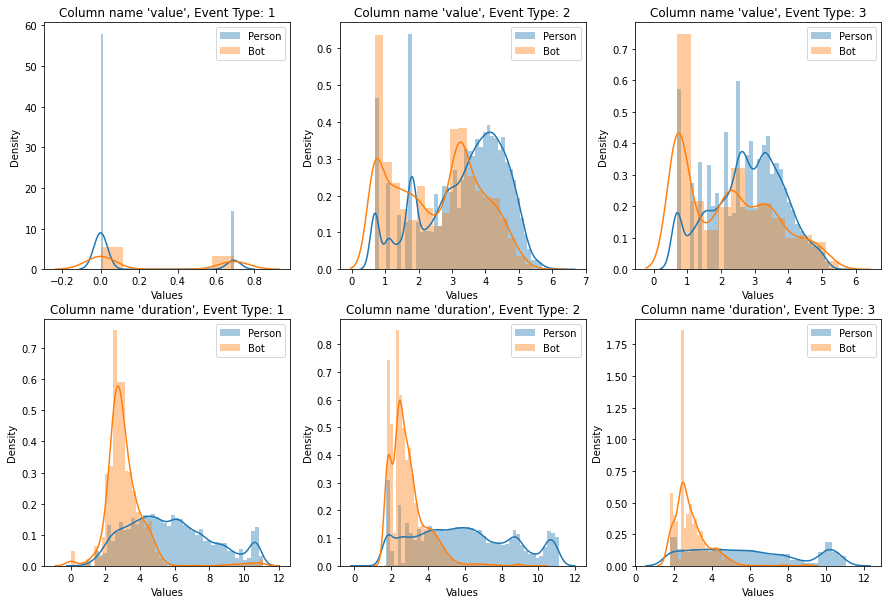

In [8]:
graph(df1=person_df, df2=bot_df, cols=['value', 'duration'], type_graph='distplot', save=True, name_fig='data_graph')

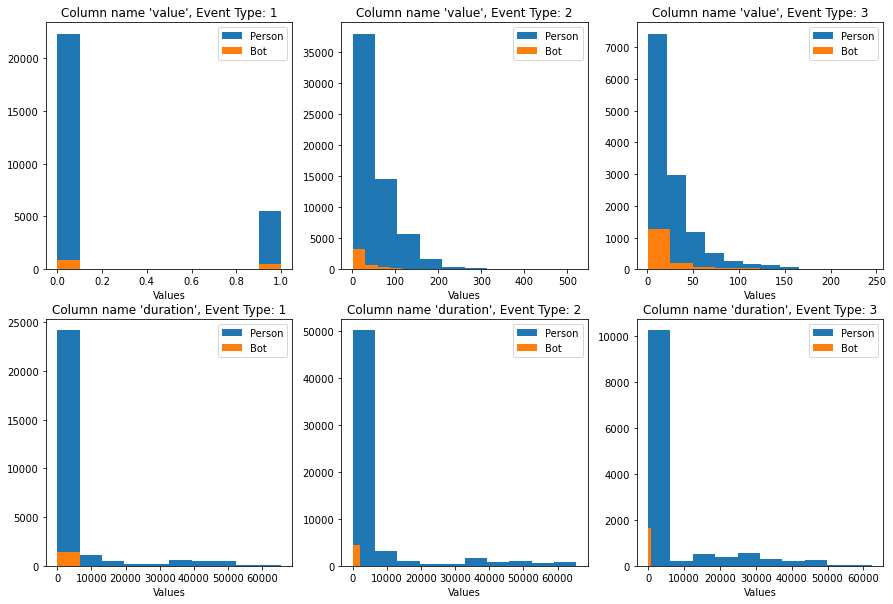

In [9]:
graph(df1=person_df, df2=bot_df, cols=['value', 'duration'], type_graph='hist', save=True, name_fig='data_graph')

In [10]:
bootstrap_bot = bootstrap(n=person_df.shape[0], arr=bot_df, cols=['value', 'duration'], col2='event_type')

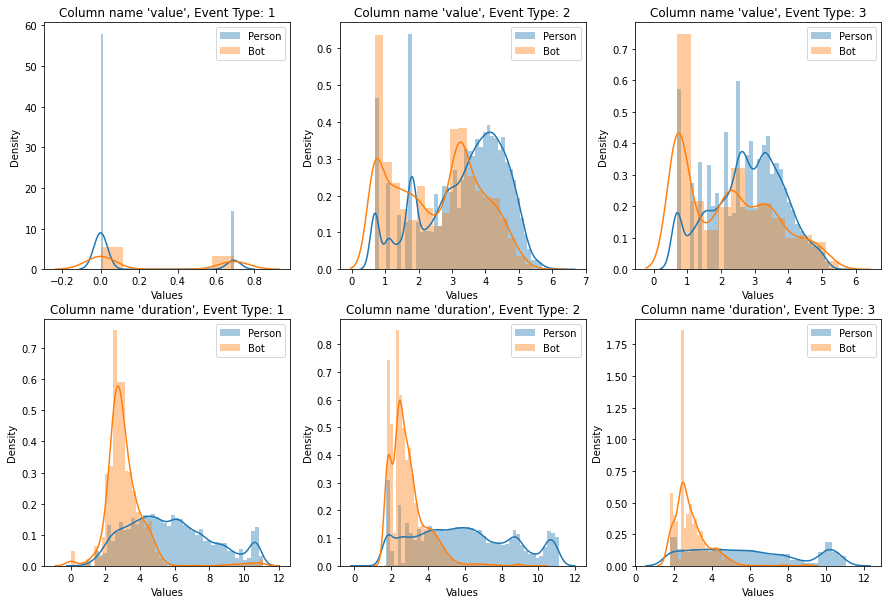

In [11]:
graph(df1=person_df, df2=bot_df, cols=['value', 'duration'], type_graph='distplot', save=True, name_fig='bootstrap_graph')

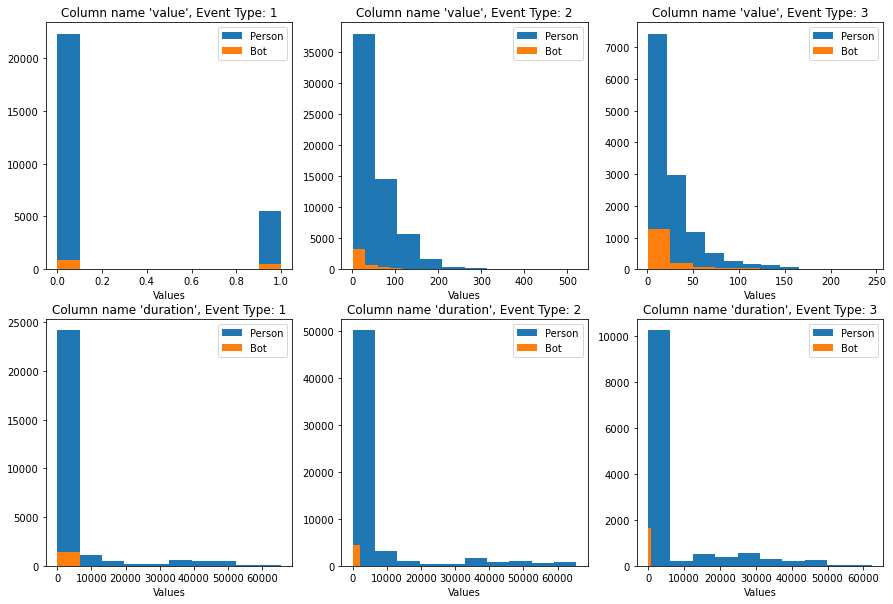

In [12]:
graph(df1=person_df, df2=bot_df, cols=['value', 'duration'], type_graph='hist', save=True, name_fig='bootstrap_graph')

In [13]:
bootstrap_bot['class'] = 0
person_df['class'] = 1

In [14]:
df = pd.concat([person_df, bootstrap_bot])

In [15]:
df.shape

(201655, 6)

In [16]:
df.head()

,user_id,event_type,value,duration,timestamp,class
0,1.491655e+09,1,0,148,2022-01-30 16:01:01,1
1,1.541245e+09,2,72,14147,2022-01-30 16:01:01,1
2,1.541245e+09,3,36,14147,2022-01-30 16:01:01,1
3,2.968375e+09,1,0,114,2022-01-30 16:01:01,1
4,3.579288e+09,1,0,1567,2022-01-30 16:01:01,1


In [17]:
X = df.loc[:, ['event_type', 'value', 'duration']]
y = df['class']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [19]:
scaler = StandardScaler()
X_train_pre = scaler.fit_transform(X_train)
X_test_pre = scaler.transform(X_test)

### Base Pipeline

#### LogisticRegression

In [20]:
parameters = {'penalty':('l1', 'l2'), 'C':[0.01, 0.1, 1, 10, 100]}
logreg = LogisticRegression(random_state=23, solver='liblinear')

In [21]:
clf = GridSearchCV(logreg, parameters)
clf.fit(X_train_pre, y_train)

GridSearchCV(estimator=LogisticRegression(random_state=23, solver='liblinear'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ('l1', 'l2')})

In [22]:
params = clf.best_params_

In [23]:
logreg = LogisticRegression(random_state=23, solver='liblinear', **params)

In [24]:
logreg.fit(X_train_pre, y_train)

LogisticRegression(C=100, random_state=23, solver='liblinear')

In [25]:
y_pred = logreg.predict(X_test_pre)

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.90      0.77     20165
           1       0.85      0.58      0.69     20166

    accuracy                           0.74     40331
   macro avg       0.76      0.74      0.73     40331
weighted avg       0.76      0.74      0.73     40331



#### LightGBM Optuna

In [100]:
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import log_loss

def objective(trial, X, y):
    cv_scores =[]
    
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [1000]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01, 0.1]),
        "num_leaves": trial.suggest_categorical("num_leaves", [5, 10]),
        "max_depth": trial.suggest_categorical("max_depth", [5, 10]),
        "min_split_gain": trial.suggest_categorical("min_split_gain", [0, 0.5]),
        "min_child_samples": trial.suggest_categorical("min_child_samples", [1, 5]),
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt"]),
        "reg_alpha": trial.suggest_categorical("reg_alpha", [0, 1, 10]),
        "reg_lambda": trial.suggest_categorical("reg_lambda", [0, 1, 10])}
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    model = lgb.LGBMClassifier(objective="binary", 
                               class_weight='balanced', 
                               random_state=23, 
                               subsample=1.0, 
                               subsample_freq=10, 
                               colsample_bytree=0.85,
                               **param_grid)
    model.fit(X_train,
              y_train,
              eval_set = [(X_test, y_test)],
              eval_metric="binary_logloss",
              early_stopping_rounds=10,
              verbose=-1,
              callbacks=[LightGBMPruningCallback(trial, metric="binary_logloss")])
        
    preds = model.predict_proba(X_test)
    cv_scores.append(log_loss(y_test, preds))

    return cv_scores

In [101]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X_train_pre, y_train)

n_trials = 100

optim = study.optimize(func, n_trials=n_trials)
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

[I 2022-02-07 19:31:39,232] A new study created in memory with name: LGBM Classifier
[I 2022-02-07 19:31:41,318] Trial 0 finished with value: 0.6535582211724887 and parameters: {'n_estimators': 1000, 'learning_rate': 0.0001, 'num_leaves': 5, 'max_depth': 10, 'min_split_gain': 0, 'min_child_samples': 5, 'boosting_type': 'gbdt', 'reg_alpha': 0, 'reg_lambda': 10}. Best is trial 0 with value: 0.6535582211724887.
[I 2022-02-07 19:31:43,336] Trial 1 finished with value: 0.3595941321101914 and parameters: {'n_estimators': 1000, 'learning_rate': 0.1, 'num_leaves': 5, 'max_depth': 10, 'min_split_gain': 0, 'min_child_samples': 1, 'boosting_type': 'gbdt', 'reg_alpha': 0, 'reg_lambda': 10}. Best is trial 1 with value: 0.3595941321101914.
[I 2022-02-07 19:31:45,466] Trial 2 finished with value: 0.3808277322996819 and parameters: {'n_estimators': 1000, 'learning_rate': 0.01, 'num_leaves': 5, 'max_depth': 5, 'min_split_gain': 0, 'min_child_samples': 5, 'boosting_type': 'gbdt', 'reg_alpha': 10, 'reg_l

	Best value (rmse): 0.34782
	Best params:


In [102]:
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

		n_estimators: 1000
		learning_rate: 0.1
		num_leaves: 10
		max_depth: 10
		min_split_gain: 0
		min_child_samples: 1
		boosting_type: gbdt
		reg_alpha: 0
		reg_lambda: 0


In [179]:
best_params = {'n_estimators': 1000,
               'learning_rate': 0.01,
               'max_depth': 5,
               'boosting_type': 'gbdt'}

              precision    recall  f1-score   support

           0       0.81      0.86      0.84     20165
           1       0.85      0.80      0.83     20166

    accuracy                           0.83     40331
   macro avg       0.83      0.83      0.83     40331
weighted avg       0.83      0.83      0.83     40331



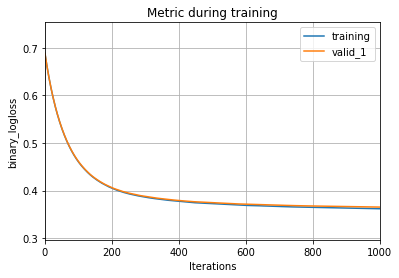

In [180]:
lgb_best = lgb.LGBMClassifier(objective="binary",
                          class_weight='balanced', 
                          random_state=23,
                          **best_params)

lgb_best_fit = lgb_best.fit(X_train_pre,
                            y_train,
                            eval_set = [(X_train_pre, y_train), (X_test_pre, y_test)],
                            eval_metric="binary_logloss",
                            verbose=-1,
                            early_stopping_rounds=10)

lgb.plot_metric(lgb_best_fit)

y_pred_test = lgb_best_fit.predict(X_test_pre)
print(classification_report(y_test, y_pred_test))

#### SGDClassifier

In [185]:
sgd = SGDClassifier(loss='hinge', random_state=23, alpha=0.000046, penalty='elasticnet')
sgd = sgd.fit(X_train_pre, y_train)

In [186]:
y_pred_test = sgd.predict(X_test_pre)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.64      0.93      0.76     20165
           1       0.87      0.49      0.63     20166

    accuracy                           0.71     40331
   macro avg       0.76      0.71      0.69     40331
weighted avg       0.76      0.71      0.69     40331



#### DecisionTreeClassifier

In [187]:
tree = DecisionTreeClassifier(random_state=23, 
                              min_samples_split=5, 
                              class_weight='balanced',
                             ).fit(X_train_pre, y_train)

In [188]:
y_pred_test = tree.predict(X_test_pre)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83     20165
           1       0.87      0.76      0.81     20166

    accuracy                           0.82     40331
   macro avg       0.83      0.82      0.82     40331
weighted avg       0.83      0.82      0.82     40331



#### KNeighborsClassifier

In [213]:
knn = KNeighborsClassifier(n_neighbors=6).fit(X_train_pre, y_train)

In [214]:
y_pred_test = knn.predict(X_test_pre)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83     20165
           1       0.87      0.74      0.80     20166

    accuracy                           0.81     40331
   macro avg       0.82      0.81      0.81     40331
weighted avg       0.82      0.81      0.81     40331

